# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file  = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = X_train.shape[0]
# TODO: Number of testing examples.
n_test  = X_test.shape[0]
# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape
# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# Visualizations will be shown in the notebook.
%matplotlib inline

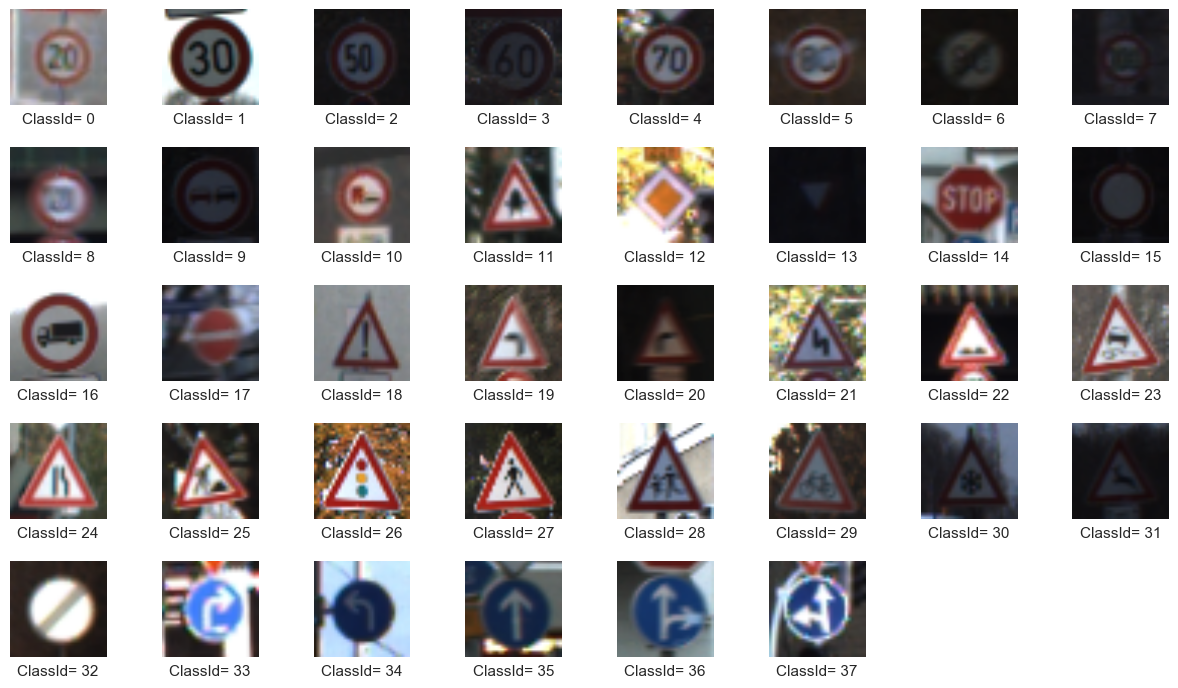

In [4]:
# extract a random sample image from each class of an image and plot it
n_cols = 8
n_rows = round(n_classes/n_cols)
df_train_labels = pd.DataFrame(y_train).rename(columns={0:'ClassId'})
class_sample_dict = {k:np.random.choice(list(v.index)) for k,v in list(df_train_labels.groupby('ClassId'))}
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,7))
axes = ax.flatten()
for axi,(k,v) in zip(axes[:-2], class_sample_dict.items()):
    axi.imshow(X_train[v])
    axi.set_xlabel('ClassId= {}'.format(k))
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
plt.tight_layout()
fig.delaxes(ax[-1,-2])
fig.delaxes(ax[-1,-1])

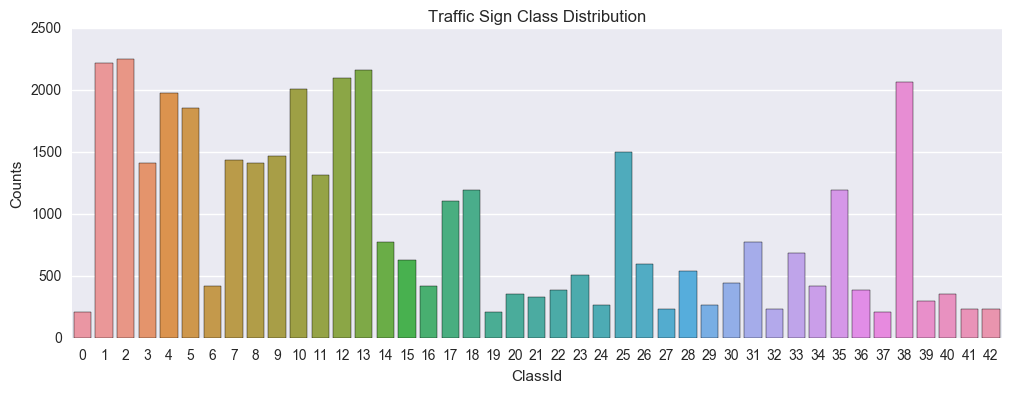

In [5]:
# visualize Traffic sign distribution count occurences according to class
sign_distribution = dict(Counter(y_train))
df_signs = pd.read_csv("signnames.csv")
df_signs['Count'] = df_signs.ClassId.map(lambda x: sign_distribution[x])
df_signs = df_signs[['ClassId', 'Count', 'SignName']]
fig = plt.figure(figsize=(12,4))
sns.barplot(df_signs.ClassId, df_signs.Count)
plt.ylabel("Counts")
plt.title("Traffic Sign Class Distribution")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preprocessing of Datasets

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2

def normalize_greyscale(data, **kwargs):
    # normalize the image with min-max scaling
    # params = {'a':-0.5, 'b': 0.5, 'min':0, 'max':255}
    # (a,b) = (0.1,0.9); (min,max) = (0,255.0)
    a,b = kwargs['a'], kwargs['b']
    min_val,max_val = kwargs['min'], kwargs['max']
    return a + ( ((data - min_val)*(b-a))/(max_val - min_val) )

def normalize_channel(data, channel, **kwargs):
    # for each channel: RGB, normalize to fall witin -1 to 1 scale
    data = data.astype(float)
    data = (data - 128.)/128.
    return data

def standardize_data(data, **kwargs):
    # assumes data as X_train
    data_sc = data - data.mean()
    if kwargs['standardize']: data_sc = data_sc/data.std()
    print("Dataset Mean: {}, Std: {:.2}".format(int(data_sc.mean()), data_sc.std()) )
    return data_sc

def log_dataset(features, labels):
    n_features, n_labels, n_class = (len(features), len(labels), labels.shape[1])
    s = "Number Features: {}, Number Labels: {}, Number Classes: {}"
    print(s.format(n_features, n_labels, n_class))
    s = "Labels Shape: {}, Features Shape: {}, Mean: {:.2f}, Std: {:.2f}"
    print(s.format(labels.shape, features.shape, np.mean(features), np.std(features)))
    
def preprocess_pipeline(features, labels, ohe_encoder, **kwargs):
    # Shuffle each partition 
    features, labels = shuffle(features, labels)
    # ALT: Pad Image Size
    # Standardize RGB data, not converting to greyscale
    features = standardize_data(features, **{'standardize': True})
    # OHE labels 
    labels = ohe_encoder.transform(labels).astype(np.float32)
    # TBD: Localized Histogram Equalization
    return features, labels
  
    
# split the training into training/validation in a stratified fashion    
X_train_sl, X_validation_sl, y_train_sl, y_validation_sl = \
train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)
train, validation, test = ((X_train_sl, y_train_sl),(X_validation_sl, y_validation_sl),(X_test, y_test))
# preprocess data, OHE object separate from pipeline to transform datasets based on training data
encoder = LabelBinarizer()
encoder.fit(y_train_sl)
X_train_pre, Y_train_pre = preprocess_pipeline(*train, encoder)
X_validation_pre, Y_validation_pre = preprocess_pipeline(*validation, encoder)
X_test_pre, Y_test_pre = preprocess_pipeline(*test, encoder)
# log information
train, validation, test = ((X_train_pre, Y_train_pre),(X_validation_pre, Y_validation_pre),(X_test_pre, Y_test_pre))
_ = [log_dataset(*data) for data in [train, validation, test] ]

Dataset Mean: 0, Std: 1.0
Dataset Mean: 0, Std: 1.0
Dataset Mean: 0, Std: 1.0
Number Features: 27446, Number Labels: 27446, Number Classes: 43
Labels Shape: (27446, 43), Features Shape: (27446, 32, 32, 3), Mean: -0.00, Std: 1.00
Number Features: 11763, Number Labels: 11763, Number Classes: 43
Labels Shape: (11763, 43), Features Shape: (11763, 32, 32, 3), Mean: 0.00, Std: 1.00
Number Features: 12630, Number Labels: 12630, Number Classes: 43
Labels Shape: (12630, 43), Features Shape: (12630, 32, 32, 3), Mean: 0.00, Std: 1.00


23899 (27446, 32, 32, 3)
Dataset Mean: 0, Std: 4.5e+01
Dataset Mean: 0, Std: 1.0


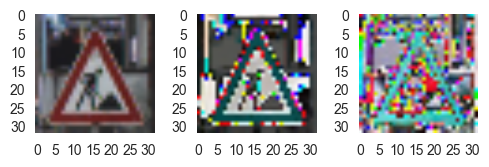

In [7]:
# example of scaling effect
rand_idx = np.random.randint(low=0, high=len(X_train_sl), size=1)[0]
print(rand_idx, X_train_sl.shape)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(5,8))
_ = [axi.grid(False) for axi in [ax1,ax2,ax3]]
_ = ax1.imshow(X_train_sl[rand_idx, :,:,:])
_ = ax2.imshow(standardize_data(X_train_sl[rand_idx], **{'standardize': False}) )
_ = ax3.imshow(standardize_data(X_train_sl[rand_idx], **{'standardize': True})  )
plt.tight_layout()

#### Training Set Data Augumentation

In [ ]:
# TBD: Data Augumentation
# Apply only to training set
# Shuffle Training Set afterwards
# Depends on type of image that would find in real world
from PIL import Image
def augment(image_data):
    # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]
    
    
    
    
    
    # rotate image by given degrees (e.g. 45)
    degrees = np.random.randint(0,180)
    rotated = Image.Image.rotate(image_data, degrees)

    
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_features[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    
    # add random blur to image
    # flip an image (horizontal or vertical)
    # crop an image from original dimensions, padding optional
    
    # image_data = Image.fromarray(image_data.eval())
    # convert image to tensor
    rotated_tensor = tf.convert_to_tensor(np.array(rotated))
    
# http://machinelearningmastery.com/image-augmentation-deep-learning-keras/
# http://florianmuellerklein.github.io/cnn_streetview/
# http://stackoverflow.com/questions/37529571/how-is-data-augmentation-implemented-in-tensorflow
# http://stackoverflow.com/questions/40498185/data-augmentation-implementation-using-tensorflow

In [8]:
# Model Architecture 
import tensorflow as tf
greyscale  = False
n_channels = 1 if greyscale else 3
dimensions = (X_train.shape[1], X_train.shape[2])
# define hyperparameter and loss configuration
config = {'num_epochs': 50, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_proba': 0.5}
config.update({'model': 'ckpts/model_traffic'})
config.update({'scenario': 'dense'})
config.update({'log_step': 1})
config.update({'optimizer_fn': tf.train.AdamOptimizer})

In [71]:
from tensorflow.contrib.layers import flatten
import tf_nn_utils as tf_utils

def apply_batch_norm(layer_in, tensors, scope_fn):
    batch_norm = tf.cond(tensors['tensor_phase'], 
        lambda: tf.contrib.layers.batch_norm(layer_in, activation_fn=tf.nn.relu,  updates_collections=None, 
                                             is_training=True,  scale=True, scope=scope_fn),
        lambda: tf.contrib.layers.batch_norm(layer_in, activation_fn =tf.nn.relu, updates_collections=None, 
                                             is_training=False, scale=True, reuse=True, scope=scope_fn))
    return batch_norm


def apply_conv_layer(layer_in, kernel, depth, tensors, **kwargs):
    mu, sigma = (0, 0.01)
    # depth is in format(input_depth, output_depth)
    input_depth, output_depth = depth
    weights_shape = (*kernel, *depth)
    conv_W = tf.Variable(tf.truncated_normal(shape=weights_shape, mean = mu, stddev = sigma), 'weights')
    conv_b = tf.Variable(tf.zeros(output_depth), 'bias')
    conv   = tf.nn.conv2d(layer_in, conv_W, strides=[1, 1, 1, 1], padding='SAME')
    conv   = tf.nn.bias_add(conv , conv_b)
    # apply core layer attributes 
    return apply_layer_attr(conv, "conv", tensors, **kwargs)

def apply_max_pooling(layer_in, kernel=(2,2), strides=(2,2), **kwargs):
    # Same output shape for padding = 'VALID' or 'SAME'
    # Per max pooling: kernel = {2x2 or 3x3} with a Stride of 2
    kernel_dim = [1, *kernel, 1]
    stride_dim = [1, *strides, 1]
    conv_pool = tf.nn.max_pool(layer_in, ksize=kernel_dim, strides=stride_dim, padding='VALID')
    return conv_pool
    
def apply_fclayer(layer_in, input_size, output_size, tensors, **kwargs):
    with tf.name_scope('preactivation'):
        mu, sigma = (0, 0.01)
        fc = tf.Variable(tf.truncated_normal(shape=(input_size, output_size), mean = mu, stddev = sigma))
        # TBD: for batchnorm, should we do not include the bias, causes issue in dimension computation
        if kwargs['bias']: 
            fc_b = tf.Variable(tf.zeros(output_size))
            conv = tf.matmul(layer_in, fc)
            fc   = tf.nn.bias_add(conv, fc_b)
        tf.summary.histogram('preactivation', fc)
    # apply core attri
    return apply_layer_attr(fc, "fc", tensors, **kwargs)
        
def apply_layer_attr(layer_in, layer_prefix, tensors, **kwargs):
    # apply batchnorm before activation (between linear and non-linear layers): unit gaussian activations
    with tf.name_scope('batchnorm'):
        if kwargs['batchnorm']:
            scope_name = layer_prefix + '/batchnorm_' + str(kwargs['id'])
            layer_in = apply_batch_norm(layer_in, tensors, scope_name)
            tf.summary.histogram('batchnorm', layer_in)
    # apply activation 
    with tf.name_scope('activation'):
        if kwargs['activation']: 
            layer_in = tf.nn.relu(layer_in, name='activation')
            tf.summary.histogram('activations',  layer_in)
    # apply maxpooling, should be done before dropout layer 
    with tf.name_scope('pooling'):
        if kwargs['pooling']:
            layer_in = apply_max_pooling(layer_in, kernel=(2,2), strides=(2,2), **kwargs)
            tf.summary.histogram('pooling', layer_in)
    # apply dropout after activation
    # when we apply batchnorm, we may not require dropout or use less dropout: acts as regulalizer
    with tf.name_scope('dropout'):
        # no dropout applied on when activation not applied
        if (kwargs['dropout'] and kwargs['activation']):
            layer_in = tf.nn.dropout(fc, dropout_keep_prob)
            tf.summary.histogram('dropout', layer_in)
    return layer_in 


def calc_dimensions(dim, kernel, strides, padding):
    # tensor input format:  [batch, height, width, channels]
    # tensor kernel format: [kernel_height, kernel_width, input_depth, output_depth]
    # kernel height and width of same dimensions
    in_height, in_width = dim
    if padding == 'SAME':
        out_height = np.ceil(float(in_height) / float(strides))
        out_width  = np.ceil(float(in_width)  / float(strides))
    elif padding == 'VALID':
        out_height = np.ceil(float(in_height - kernel  + 1)  / float(strides))
        out_width  = np.ceil(float(in_width  - kernel  + 1) / float(strides))
        
    # spatial dimensions: output = (N-F)/S + 1
    # zero pading: (F-1)/2 => {F=3:Pad=1, F=5:Pad=2, F=7:Pad=3}
    return out_height, out_width

def create_network(tensors, num_classes):
    kernel=(3,3)
    get_dim = lambda x_t: tuple( [it.value for it in x_t.get_shape()][1:] )
    input_height, input_width, input_depth, output_depth = (*get_dim(tensors['tensor_features']), 16)
    print(input_depth, output_depth)
    
    params = {'id':1,'activation':True, 'dropout':False, 'pooling':False, 'batchnorm':True, 'bias': True}    
    conv1 = apply_conv_layer(tensors['tensor_features'], kernel, (input_depth, output_depth), tensors, **params)
    input_height, input_width, input_depth = get_dim(conv1)
    output_depth = input_depth*2
    print(input_depth, output_depth)

    params = {'id':2,'activation':True, 'dropout':False, 'pooling':True, 'batchnorm':True, 'bias': True}    
    conv2 = apply_conv_layer(conv1, kernel, (input_depth, output_depth), tensors, **params)
    input_height, input_width, input_depth = get_dim(conv2)
    output_depth = input_depth*2
    print(input_depth, output_depth)
    fc0 = tf.contrib.layers.flatten(conv2)

    tf.summary.image('fc_input', tensors['tensor_features'], num_classes)
    params = {'id':1,'activation':True, 'dropout':False, 'pooling': False, 'batchnorm':True, 'bias': True}
    fc1  = apply_fclayer(fc0, int(fc0.get_shape()[1]), 512, tensors, **params)
    params = {'id':2,'activation':True, 'dropout':False, 'pooling': False, 'batchnorm':True, 'bias': True}
    fc2  = apply_fclayer(fc1, int(fc1.get_shape()[1]), 256, tensors, **params)
    # no activation for 
    params = {'id':3,'activation':False,'dropout':False, 'pooling': False, 'batchnorm':True, 'bias': True}
    logits = apply_fclayer(fc2, int(fc2.get_shape()[1]), num_classes, tensors, **params)
    
    
    """"
    
    fc0  = flatten(tensors['tensor_features'])
    tf.summary.image('fc_input', tensors['tensor_features'], num_classes)
    params = {'id':1,'activation':True, 'dropout':False,'batchnorm':True, 'bias': True}
    fc1  = apply_fclayer(fc0, int(fc0.get_shape()[1]), 512, tensors, **params)
    params = {'id':2,'activation':True, 'dropout':False,'batchnorm':True, 'bias': True}
    fc2  = apply_fclayer(fc1, int(fc1.get_shape()[1]), 256, tensors, **params)
    # no activation for 
    params = {'id':3,'activation':False,'dropout':False,'batchnorm':True,'bias': True}
    logits = apply_fclayer(fc2, int(fc2.get_shape()[1]), num_classes, tensors, **params)
    return logits

    print('ak', fc0.get_shape())        
    #output_height, output_width = calc_dimensions(dim=(input_height,input_width), kernel=(3,3), strides=1, padding='SAME')

    """
    return logits

def init_graph(dimension_data, num_channels, num_classes):
    # define graph configuration
    tf.reset_default_graph()
    # create tensor as 4D, not 2D (avoid to have to reshape)
    # x = tf.placeholder(tf.float32, [None, n_inputs], name='features')
    x = tf.placeholder(tf.float32, [None, *dimension_data, num_channels], name='features')
    y = tf.placeholder(tf.float32, [None, num_classes], name='labels')
    dropout_proba = tf.placeholder(tf.float32, name='keep_prob')
    is_train = tf.placeholder(tf.bool, name='is_train')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    print("Tensorflow Features Shape: {}, Labels Shape: {}".format(x.get_shape(), y.get_shape()) )
    return {
        'tensor_features': x,
        'tensor_yhat': y, 
        'tensor_phase': is_train, 
        'tensor_dropout_proba': dropout_proba, 
        'tensor_lr': learning_rate
    }
    
# create initial model
tensor_dict = init_graph(dimensions, n_channels, n_classes)
logits = create_network(tensor_dict, n_classes)
operations = tf_utils.optimize(logits, tensor_dict['tensor_yhat'], **config)
config.update(operations)
# train model 
_ = tf_utils.train(train, validation, tensor_dict, **config)
# final evaluation on test set 
tf_utils.model_evaluate(test, tensor_dict, **config)

Tensorflow Features Shape: (?, 32, 32, 3), Labels Shape: (?, 43)
3 16
16 32
32 64
Failed to restore checkpoint, initializing variables
EPOCH: 0, 'Tr Loss': 1.022, Val Loss: 3.712, Tr Acc: 0.841, Val Acc: 0.053
EPOCH: 1, 'Tr Loss': 0.298, Val Loss: 3.686, Tr Acc: 0.985, Val Acc: 0.031
EPOCH: 2, 'Tr Loss': 0.180, Val Loss: 3.662, Tr Acc: 0.994, Val Acc: 0.057
EPOCH: 3, 'Tr Loss': 0.134, Val Loss: 3.642, Tr Acc: 0.994, Val Acc: 0.057


KeyboardInterrupt: 

In [115]:
m = n_classes
N = 32*32*3
print ( np.sqrt( (m+2)*N ) + 2*np.sqrt(N/(m+2)) )
N=400
print ( m*np.sqrt(N/(m+2)) )

388.33113018
128.20123071


In [ ]:
def calc_filter_dims(**kwargs):
    # considered as 'valid' padding: pad values w/zero(0) along border of image
    # new_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    # new_width  = ceil(float(in_width  - filter_width  + 1) / float(strides[2]))
    filter_height = ceil( float( kwargs['input_height'] + 1 - 
                          (kwargs['output_height'] * float(kwargs['strides_height'])) ) )
    filter_width  = ceil( float( kwargs['input_width'] + 1 - 
                          (kwargs['output_width'] * float(kwargs['strides_width'])) ) )
    return (int(filter_height), int(filter_width))


def apply_conv2d(layer_in, **kwargs):
    mu, sigma = (0, 0.1)
    # calculate convolution
    filter_height, filter_width = calc_filter_dims(**kwargs)
    weights_shape = (filter_height, filter_width, kwargs['input_depth'], kwargs['output_depth'])
    conv_W = tf.Variable(tf.truncated_normal(shape=weights_shape, mean = mu, stddev = sigma), 'weights')
    conv_b = tf.Variable(tf.zeros(kwargs['output_depth']), 'bias')
    conv   = tf.nn.conv2d(layer_in, conv_W, strides=[1, 1, 1, 1], padding='VALID')
    conv   = tf.nn.bias_add(conv , conv_b)
    # apply activation (ReLU)
    conv = tf.nn.relu(conv)
    return conv



In [ ]:
# visualizations
# http://stackoverflow.com/questions/33802336/visualizing-output-of-convolutional-layer-in-tensorflow
# https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/
# https://www.tensorflow.org/versions/master/how_tos/image_retraining/

def define_metrics(W, b, cost_function):
    w_h = tf.histogram_summary("weights", W)
    b_h = tf.histogram_summary("biases", b)
    tf.scalar_summary("cost_function", cost_function)
    merged_summary_op = tf.merge_all_summaries()

In [ ]:
# https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/convolution
# https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/pooling#max_pool

# localhost:6006
# logdir=<path where summary writer summarized it's data to>
# tensorboard --logdir=path/to/log-directory

#from tensorflow.contrib import layers
#from tensorflow.contrib import learn
#https://www.tensorflow.org/api_docs/python/contrib.layers/
#https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim/python/slim/nets

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

- For each of the Training/Validation/Tests splits:
    - Shuffle the dataset so the neural network cannot learn from any specific ordering
    - Keep the image as RGB, but standardize the image (mean=0, std=1) rather than greyscale
    - One-Hot Encode (OHE) the labels so instead of 1D, it is now a nx43 matrix
        - OHE was based on the orginal training data, in case not all splits have the same classes existent
- TBD: Histogram Equalization so effect of brightness is removed

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

- Split the training set into Training/Validation with a 70/30 split.
    - Rather than preprocessing the entire training set first, split the data first and then preprocess 
    - Stratify the split, so a roughly equal distribution of classes is performed between training and validation
- Additional Data Augumentation was performed on the training set only
    - Using the validation data to evaluate the peformance from the augumented images on the training set
    - Helps determine how well our model responds to data augumentation

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
- Preprocess Data: standardize data, RGB Channels (not Greyscale)
- Training Data: Preprocess + Data Augumentation

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

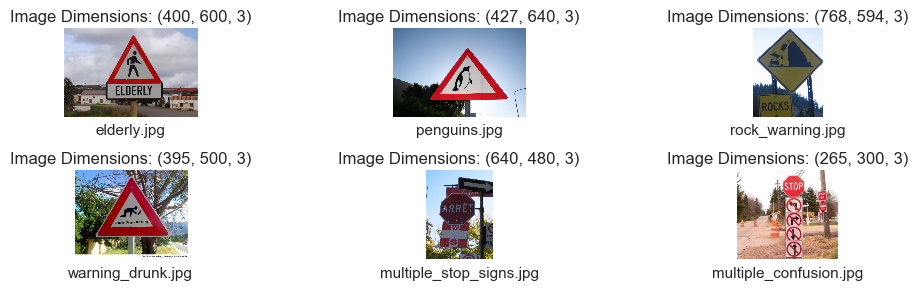

In [249]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def set_axi_opts(axi, **kwargs):
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
    if 'title'  in kwargs: axi.set_title(kwargs['title'])
    if 'xlabel' in kwargs: axi.set_xlabel(kwargs['xlabel'])

image_files = ['elderly.jpg', 'penguins.jpg', 'rock_warning.jpg', 'warning_drunk.jpg', 
              'multiple_stop_signs.jpg', 'multiple_confusion.jpg']
fig, ax = plt.subplots(2,3, figsize=(10,3))
for axi, filename in zip(ax.flatten(), image_files):
    image_data = mpimg.imread("images/" + filename)
    axi.imshow(image_data)
    set_axi_opts(axi, **{'title': 'Image Dimensions: {}'.format(image_data.shape), 'xlabel': filename})
plt.tight_layout()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
Images were retrieved via google image search, primarily attempting to find images that were not strictly in the training set as is.
- Images with multiple signs in them cause confusion
- Images where we do not have a particular class associated to them (e.g. animals)
- Abstract or Foreign based Shape signs (not specifically to the language text)

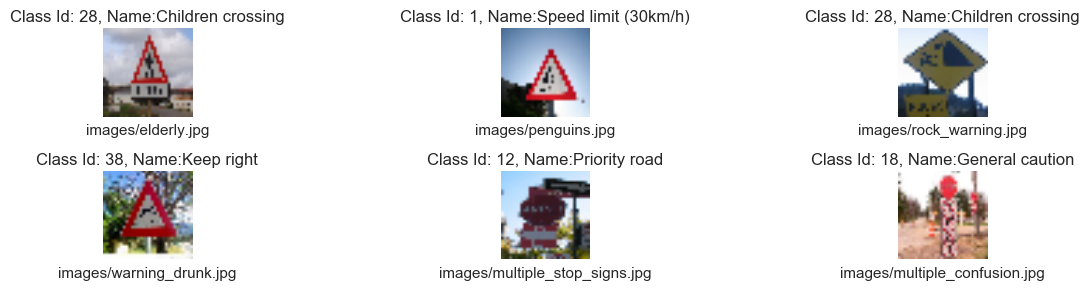

In [250]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def make_prediction(sess, image_data, logits):
    cls = sess.run(tf.argmax(logits, 1), feed_dict={x: [image_data]})[0]
    return cls 

def show_image_predictions(sess, axi, image_file, logits):
    image_data = mpimg.imread(image_file)
    resized_image_data = cv2.resize(image_data, (32, 32)) 
    cls = make_prediction(sess, resized_image_data, logits)
    sign_name = df_signs[df_signs.ClassId == cls].SignName.values[0]
    axi.imshow(resized_image_data)
    set_axi_opts(axi, **{'title': "Class Id: {}, Name:{}".format(cls, sign_name), 'xlabel': image_file})
    return cls
    
cls_yhat = []
fig, ax = plt.subplots(2,3, figsize=(12,3))
for axi, filename in zip(ax.flatten(), image_files):
    cls_yhat.append( show_image_predictions(tr_session, axi, 'images/' + filename, logits) )
plt.tight_layout()

Training Image Examples for Similar Classes


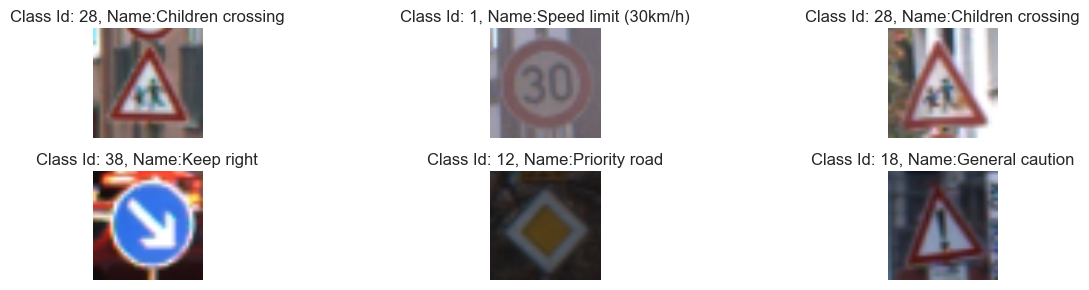

In [254]:
# show training images for these classes 
print("Training Image Examples for Similar Classes")
fig, ax = plt.subplots(2,3, figsize=(12,3))
for axi, cls in zip(ax.flatten(), cls_yhat):
    tr_match_indices = np.where(y_train == cls)[0]
    indice = np.random.choice(list(tr_match_indices))
    sign_name = df_signs[df_signs.ClassId == cls].SignName.values[0]
    axi.imshow(X_train[indice] )
    set_axi_opts(axi, **{'title': "Class Id: {}, Name:{}".format(cls, sign_name)})
plt.tight_layout()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
- All Images are resized to training image size (32,32,3)
- Unfortunately the model did not generalize well on the given images: only about 1/6 (~ 16-17%), as noted by the initial 'child crossing' image. As noted, as we don't have labels for these particular images. 
- Notice when there are multiple signs, the sign was indicated as 'General Caution', although not with a high probability.

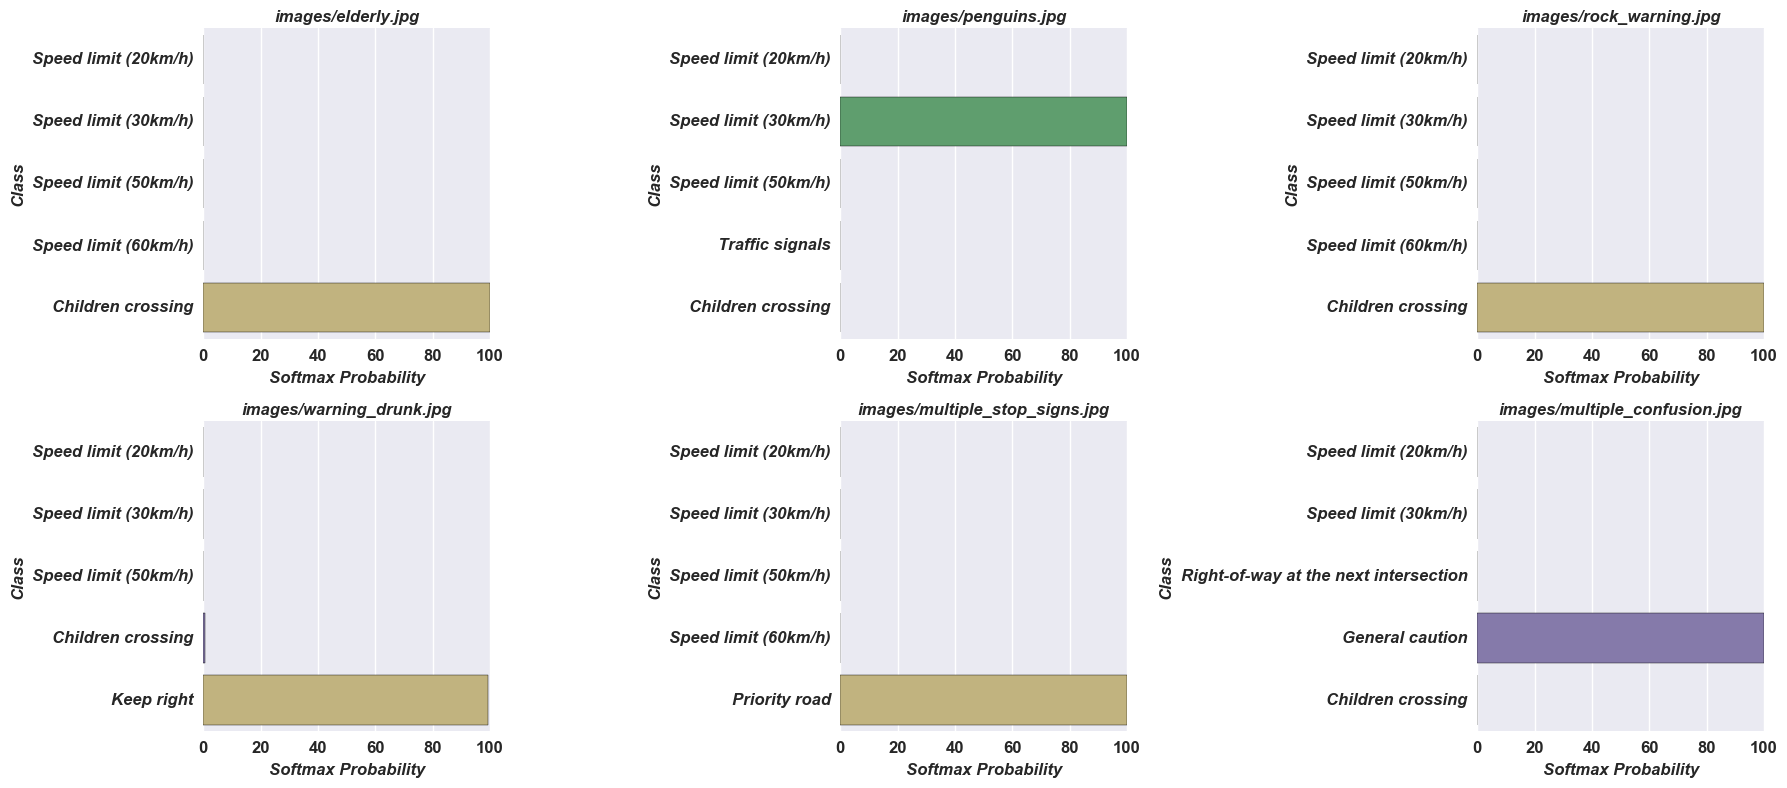

In [206]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
def calc_proba(sess, image_file, logits, k=5):
    image_data = mpimg.imread(image_file)
    resized_image_data = cv2.resize(image_data, (32, 32)) 
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=k), feed_dict={x: [resized_image_data]})
    return top_k

def show_image_proba(sess, axi, image_file, logits):
    # Create a dataframe of the pro
    vals, indices = calc_proba(tr_session, image_file, logits, k=5)
    frame = pd.DataFrame( [ indices[0], vals[0] ] ).T
    frame.columns = ['ClassId', 'Proba']
    frame.ClassId = frame.ClassId.astype(int)
    frame.Proba = frame.Proba.astype(float)
    frame.Proba *= 100
    frame['SignName'] = frame.ClassId.map(lambda x: df_signs[df_signs.ClassId == x].SignName.values[0])
    frame = frame.sort_values(by='Proba', ascending=False)
    sns.barplot(frame.Proba, frame.ClassId, orient='h', ax=axi)
    labels = [frame[frame.ClassId == int(item.get_text())].SignName.values[0] for item in axi.get_yticklabels()]
    axi.set_title(image_file, fontweight='bold', fontsize=12, style='italic')
    axi.set_yticklabels(labels, fontweight='bold', fontsize=12, style='italic')
    axi.set_ylabel('Class', fontweight='bold', fontsize=12, style='italic')
    axi.set_xlabel('Softmax Probability', fontweight='bold', fontsize=12, style='italic')
    for tick in axi.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        tick.label.set_fontweight('bold')
    return {'image': image_file, 'metrics': frame}

df_proba = pd.DataFrame()
fig,ax = plt.subplots(2,3, figsize=(18,8))    
for axi, image_name in zip(ax.flatten(), image_files):    
    df_proba = df_proba.append( show_image_proba(tr_session, axi, 'images/' + image_name, logits), ignore_index=True )
plt.tight_layout()

In [207]:
# example of dataframe metric aggregations
df_proba.metrics[3]

,ClassId,Proba,SignName
0,38,99.359339,Keep right
1,28,0.640656,Children crossing
2,0,0.000000,Speed limit (20km/h)
3,1,0.000000,Speed limit (30km/h)
4,2,0.000000,Speed limit (50km/h)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.